# Milestone project 2: SkimLit

The purpose of this notebook is to build an NLP model to make a reading medical abstracts easier.


The paper we're replicating (the source of the dataset that we'll be using) is avliable here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is avliable here: https://arxiv.org/abs/1612.05251

If you want to find the ground truth for this notebook just go to github mrdbourke.

## Confirm access to a a GPU

This is very redundant and what he does is use an online gpu that you can't access all the time. So this way is the local way (better way)

In [ ]:
import tensorflow as tf
gpu = tf.config.list_physical_devices('GPU')
print(gpu)
# There is a gpu at gpu address. Use len to check how many (you can clearly see that there is only one)
print(f'Number of gpus: {len(gpu)}')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of gpus: 1


## Get data

Since we'll replicate the paper above (PubMed 200k RCT) let's download the dataset. This is local, you can use wget etc, but keep it simple.

From github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
#!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

In [ ]:
# Check what files are in the PubMed_20k dataset
!dir "./pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/" 

 Volume in drive C is Windows
 Volume Serial Number is 269A-D70D

 Directory of C:\Users\mdnia\pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign

03.03.2022  16:31    <DIR>          .
03.03.2022  16:31    <DIR>          ..
03.03.2022  16:31         4ÿ880ÿ409 dev.txt
03.03.2022  16:31         4ÿ846ÿ504 test.txt
03.03.2022  16:31        29ÿ118ÿ832 train.txt
               3 File(s)     38ÿ845ÿ745 bytes
               2 Dir(s)  377ÿ006ÿ596ÿ096 bytes free


In [ ]:
# Start our experiments with the 20k dataset replaced with at sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
fil = [os.path.join(data_dir, f) for f in os.listdir(data_dir)]
fil

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target text file

In [ ]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads a filename (a text filename) and returns the lines of text as a list
  Args:
    filename: a striing containing the target filepath.
  Returns:
    A list of strings with one string per line from the target filename
  """

  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(os.path.join(data_dir, 'train.txt'))
train_lines[:35]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

List of dictionary? The way he thinks is the most valuable thing, not what he writes here. Pick it appart basically. Take one sentence from above and try to see how it would loook like. Then expand. Try first and then see what he does.

```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity .\n'
  'total_lines': 11},
  ...]
  ```


I tried to do it myself, but the task is again ambigious.

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """"
  Returns a list of dictionaries

  Takes in filename, reads its content and sorts through each line, 
  extracting things like the target label, the text of the sentence, 
  how many sentences are in the current abstract and what sentence 
  number the target line is.
  """
  input_lines = get_lines(filename)
  abstract_lines = ""  # create and empty abstract
  abstract_samples = [] # create and empty list of abstracts

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      # iterate through each lines in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['totalt_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
      abstract_lines += line
    
  return abstract_samples

 


In [ ]:
train_file = os.path.join(data_dir, 'train.txt')
val_file = os.path.join(data_dir, 'dev.txt') # dev is another name for validation
test_file = os.path.join(data_dir, 'test.txt')

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(train_file)
val_samples = preprocess_text_with_line_numbers(val_file)
test_samples = preprocess_text_with_line_numbers(test_file)

CPU times: total: 344 ms
Wall time: 346 ms


In [ ]:
len(train_samples)

180040

In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'totalt_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'totalt_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'totalt_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'totalt_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western on

Now that our data is the format of a list of dictionaries, how about we turn it into a dataframe to further visualize our data

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,totalt_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

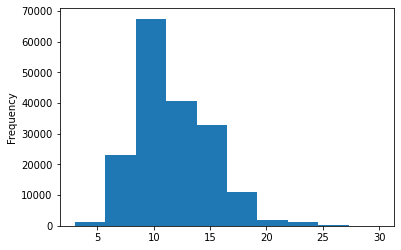

In [ ]:
# Let's check the length of different lines
train_df.totalt_lines.plot.hist();

### Get a list of sentences

In [ ]:
# Converts abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numeric labels (ML models require numeric labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

Starting with the modelling this site can provide someusefull information;

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

## Starting a series of modelling experiments....

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline

## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()),
                    ('clf', MultinomialNB())
])
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f'Our baseline model achieves an accuracy of: {baseline_score*100}%')

Our baseline model achieves an accuracy of: 72.1832384482987%


In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates metrics. Basically copy paste from sklearn
  """

  model_accuracy = accuracy_score(y_true, y_pred) * 100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}
  return model_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model_1: Conv1d 

### Preparing the data before building the deep model



In [ ]:
# How long is each sentence on average?
import numpy as np

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

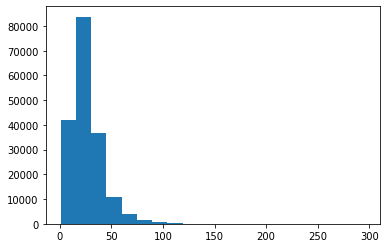

In [ ]:
# What does the distrubution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length
max(sent_lens)

296

### Creating a text vectorizer

In [ ]:
# Text vectorizer 
max_vocab_length = 68000 # The paper tells us how big the vocab is
max_length = 55          # This is the 95% percentile number

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                                    output_sequence_length=max_length,
                                                    )
text_vectorizer.adapt(train_sentences)

In [ ]:
sample_sentence = 'I peed myself in the shower tonight in my dream'
text_vectorizer(sample_sentence)

<tf.Tensor: shape=(55,), dtype=int64, numpy=
array([  389,     1,     1,     5,     2, 45607,     1,     5, 25624,
       16073,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int64)>

In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in the vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in the vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Creating a text embedding layer

In [ ]:
# Create embedding layer

embedding_layer = tf.keras.layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                            output_dim=128,
                                            #input_length=max_length,
                                            mask_zero=True) # Used when there is a sparse vecotr (a lot of zeros)
embedding_layer

In [ ]:
target_sentence = 'I peed myself in the shower tonight in my dream and op sucks dick'
print(f'Sentence before vectorization:\n {target_sentence}\n')
vecotrized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding):\n {vecotrized_sentence}')
embedded_sentence = embedding_layer(vecotrized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Shape of embedded sentence: {embedded_sentence.shape}')

Sentence before vectorization:
 I peed myself in the shower tonight in my dream and op sucks dick

Sentence after vectorization (before embedding):
 [[  389     1     1     5     2 45607     1     5 25624 16073     3  5551
      1     1     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
 [[[ 0.04405495 -0.01041608  0.01494466 ... -0.02938436  0.0435313
    0.00943456]
  [-0.04734159 -0.00124284 -0.02370697 ...  0.01546432 -0.03078562
   -0.02874564]
  [-0.04734159 -0.00124284 -0.02370697 ...  0.01546432 -0.03078562
   -0.02874564]
  ...
  [-0.04754376 -0.04876256  0.0012273  ... -0.04741775 -0.00336381
    0.03963493]
  [-0.04754376 -0.04876256  0.0012273  ... -0.04741775 -0.00336381
    0.03963493]
  [-0.04754376 -0.04876256  0.0012273  ... -0.04741775 -0.0033

## Creating datasets (important for loading the datasets fast)

In [ ]:
# Turn our data into Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# Take the Tensorflow tensorslices and turn them into prefetch etc. All to make the pipeline more efficient
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1d

In [ ]:
# Making model 1 deep conv
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Input_layer')

x = text_vectorizer(inputs) # Vectorize the input
x = embedding_layer(x) # Create embedding
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)
#x = tf.keras.layers.Conv1D(filters=32, kernel_size=5)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', name='output')(x)

model_1 = tf.keras.Model(inputs, outputs)


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 output (Dense)              (None, 5)                 325   

In [ ]:
# Build and fit the model
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# I tried full first but you can run step_per_epoch to reduce the duration
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=valid_dataset,
                        epochs=5)

Epoch 1/5
562/562 [==============================] - 10s 7ms/step - loss: 0.9292 - accuracy: 0.6321 - val_loss: 0.6986 - val_accuracy: 0.7352
Epoch 2/5
562/562 [==============================] - 4s 7ms/step - loss: 0.6657 - accuracy: 0.7518 - val_loss: 0.6435 - val_accuracy: 0.7690
Epoch 3/5
562/562 [==============================] - 4s 7ms/step - loss: 0.6250 - accuracy: 0.7716 - val_loss: 0.6033 - val_accuracy: 0.7844
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 0.5951 - accuracy: 0.7853 - val_loss: 0.5808 - val_accuracy: 0.7905
Epoch 5/5
562/562 [==============================] - 4s 7ms/step - loss: 0.5939 - accuracy: 0.7900 - val_loss: 0.5624 - val_accuracy: 0.8019


In [ ]:
# Evaluate on whole val dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 1s 2ms/step - loss: 0.5624 - accuracy: 0.8019


[0.5624154210090637, 0.8019329905509949]

In [ ]:
# Making predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[5.0408560e-01, 2.0140234e-01, 7.0122547e-02, 1.6686760e-01,
        5.7521898e-02],
       [4.8187193e-01, 3.1404141e-01, 2.2400083e-02, 1.5633518e-01,
        2.5351394e-02],
       [1.7873016e-01, 4.1673966e-03, 1.0705623e-03, 8.1598490e-01,
        4.6970006e-05],
       ...,
       [2.3530456e-05, 5.4520305e-04, 3.0886959e-03, 1.1236907e-05,
        9.9633139e-01],
       [1.2386562e-01, 3.2317150e-01, 1.7030531e-01, 9.3997583e-02,
        2.8866005e-01],
       [1.5913443e-01, 7.5681931e-01, 4.0059734e-02, 1.2560604e-02,
        3.1425908e-02]], dtype=float32)

In [ ]:
# Convert preds probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [ ]:
# Claclulate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.19330067522839,
 'precision': 0.8022432327393966,
 'recall': 0.8019330067522839,
 'f1': 0.7987342957914073}

## Model 2: Feature extraction with pretrained token embeddings

Link for what we use: https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
import tensorflow_hub as hub

hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                     trainable=False,
                                     name='universal_sentgence_encoder')

In [ ]:
# Test out the pretrained embedding on a random sentence
import random
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence:\n {random_train_sentence}')
use_embedded_sentence = hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n {use_embedded_sentence}\n')


Random sentence:
 the diagnostic efficacy was evaluated with receiver operating characteristic ( roc ) curves .
Sentence after embedding:
 [[ 1.2111420e-02 -6.2308093e-03 -5.5008575e-02 -1.4965516e-02
   6.7124225e-02 -3.4335777e-02 -1.9135442e-02 -2.1882031e-02
   2.2456292e-02  7.1933679e-02  4.5809411e-02 -8.1079468e-02
   2.2127865e-02  7.8499213e-02 -6.1249536e-02 -2.0903841e-02
   2.6565267e-02  6.9477528e-02  6.5097220e-02  5.8852237e-02
  -6.6049144e-02 -5.7268213e-03 -5.6219541e-02 -5.1293068e-02
   3.9582957e-02 -1.5493133e-02  7.1225776e-03  4.7759086e-02
  -6.3899127e-03  6.7690335e-02  4.6051577e-02  8.5072450e-02
  -5.0815687e-02 -4.8015118e-02 -6.1058728e-03  7.6779902e-02
  -5.0483368e-02  2.3366226e-02 -4.9278598e-02  1.5852870e-02
  -4.8302155e-02 -5.0699621e-02 -2.1796622e-03  4.1084751e-02
  -1.9829422e-02  4.5992415e-02 -4.6619182e-03 -7.9180270e-02
   6.6487193e-02  2.6635341e-03 -3.6184900e-02 -3.7867080e-02
  -2.9430112e-02 -3.9271913e-02 -1.4416841e-02 -3.57657

## Building and fitting an NLP feature extraction model using pretrained embeddings

In [ ]:
# Building the model
model_2 = tf.keras.Sequential([
                               hub_embedding_layer,
                               tf.keras.layers.Dense(64, activation='relu'),
                               tf.keras.layers.Dense(5, activation='softmax')
], name='model_2_hub')

model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
hisotry_2 = model_2.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)),
                        epochs=5)

Epoch 1/5
562/562 [==============================] - 6s 8ms/step - loss: 0.9493 - accuracy: 0.6361 - val_loss: 0.8082 - val_accuracy: 0.6818
Epoch 2/5
562/562 [==============================] - 5s 8ms/step - loss: 0.7800 - accuracy: 0.6957 - val_loss: 0.7659 - val_accuracy: 0.7008
Epoch 3/5
562/562 [==============================] - 5s 8ms/step - loss: 0.7651 - accuracy: 0.7065 - val_loss: 0.7527 - val_accuracy: 0.7088
Epoch 4/5
562/562 [==============================] - 5s 8ms/step - loss: 0.7345 - accuracy: 0.7178 - val_loss: 0.7287 - val_accuracy: 0.7194
Epoch 5/5
562/562 [==============================] - 5s 8ms/step - loss: 0.7452 - accuracy: 0.7144 - val_loss: 0.7104 - val_accuracy: 0.7287


In [ ]:
model_2.summary()

Model: "model_2_hub"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentgence_encoder  (None, 512)              256797824 
  (KerasLayer)                                                   
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256,830,981
Trainable params: 33,157
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Did wrong with the functional api.
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = hub_embedding_layer(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_2_func = tf.keras.Model(inputs, outputs)

model_2_func.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

model_2_func.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentgence_encoder  (None, 512)              256797824 
  (KerasLayer)                                                   
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_2_func = model_2_func.fit(train_dataset,
                                  steps_per_epoch=int(0.1*len(train_dataset)),
                                  validation_data=valid_dataset,
                                  epochs=5)

Epoch 1/5
562/562 [==============================] - 11s 19ms/step - loss: 0.9206 - accuracy: 0.6471 - val_loss: 0.7982 - val_accuracy: 0.6930
Epoch 2/5
562/562 [==============================] - 10s 18ms/step - loss: 0.7674 - accuracy: 0.7015 - val_loss: 0.7545 - val_accuracy: 0.7096
Epoch 3/5
562/562 [==============================] - 10s 19ms/step - loss: 0.7501 - accuracy: 0.7136 - val_loss: 0.7397 - val_accuracy: 0.7144
Epoch 4/5
562/562 [==============================] - 10s 18ms/step - loss: 0.7163 - accuracy: 0.7241 - val_loss: 0.7134 - val_accuracy: 0.7298
Epoch 5/5
562/562 [==============================] - 10s 18ms/step - loss: 0.7240 - accuracy: 0.7215 - val_loss: 0.6975 - val_accuracy: 0.7344


In [ ]:
# Evaluate on the whole validation dataset
model_2_func.evaluate(valid_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.6975 - accuracy: 0.7344


[0.6974918842315674, 0.7344101667404175]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[6.3077867e-01, 2.3538618e-01, 3.8076257e-03, 1.1911259e-01,
        1.0914984e-02],
       [4.4410866e-01, 4.5984438e-01, 4.5624971e-03, 8.7961234e-02,
        3.5232310e-03],
       [3.3362830e-01, 8.4794365e-02, 3.6318347e-02, 4.9107614e-01,
        5.4182805e-02],
       ...,
       [2.2359027e-03, 2.4730745e-03, 1.4425445e-01, 7.7387283e-04,
        8.5026264e-01],
       [2.4683615e-03, 1.9043958e-02, 4.4953674e-01, 1.0099807e-03,
        5.2794093e-01],
       [1.6204122e-01, 2.6355785e-01, 4.9638021e-01, 4.9319132e-03,
        7.3088840e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 72.67311002250761,
 'precision': 0.7227275238194715,
 'recall': 0.7267311002250761,
 'f1': 0.7212301908228851}

## Model 3: Conv1D with character embeddings
 
The paper which we are replicating states they used a combination of token and character-level embeddings.

Previously we've used token-level embeddings but  we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into character

def split_chars(text):
  return ' '.join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't h e   d i a g n o s t i c   e f f i c a c y   w a s   e v a l u a t e d   w i t h   r e c e i v e r   o p e r a t i n g   c h a r a c t e r i s t i c   (   r o c   )   c u r v e s   .'

In [ ]:
text = 'I hate your boobs. Not really I like them'
split_text = split_chars(text)
split_text[10]

'e'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What is the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

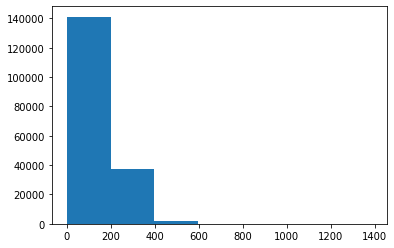

In [ ]:
# Check the distribution of our sequences at a character-level
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length that covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
random.choice(train_sentences)

'nspt significantly reduced pi at @ months post-therapy as compared to ohi .'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab '[UNK]')
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                    output_sequence_length=output_seq_char_len,
                                                    #standardize=None, # Set standardize to none if you want to have punctuation in
                                                    name='Char_vecotrizer')

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different chracter in chracter vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different chracter in chracter vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random train: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n {vectorized_chars}")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t s h   a n d   t h y r o i d   h o r m o n e   v a l u e s   w e r e   m e a s u r e d   a t   t h e   b e g i n n i n g   o f   t h e   s t u d y   a n d   @   m o n t h s   a f t e r   t r e a t m e n t   .
Length of random train: 87
Vectorized chars:
 [[ 3  9 13  5  6 10  3 13 19  8  7  4 10 13  7  8 15  7  6  2 21  5 12 16
   2  9 20  2  8  2 15  2  5  9 16  8  2 10  5  3  3 13  2 22  2 18  4  6
   6  4  6 18  7 17  3 13  2  9  3 16 10 19  5  6 10 15  7  6  3 13  9  5
  17  3  2  8  3  8  2  5  3 15  2  6  3  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embedding_layer = tf.keras.layers.Embedding(input_dim=len(char_vocab), # Number of different characters
                                                 output_dim=25,
                                                 mask_zero=True,
                                                 name='Char_embedding')
char_embedding_layer

In [ ]:
# Test out character embedding layer
print(f"Charified text:\n {random_train_chars}")
char_embed_example = char_embedding_layer(char_vectorizer([random_train_chars])) # Remember it is after vectorized and embedded
print(f"After embedding:\n {char_embed_example}") 
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 t s h   a n d   t h y r o i d   h o r m o n e   v a l u e s   w e r e   m e a s u r e d   a t   t h e   b e g i n n i n g   o f   t h e   s t u d y   a n d   @   m o n t h s   a f t e r   t r e a t m e n t   .
After embedding:
 [[[-0.03618916 -0.03895373  0.02690675 ...  0.01382062 -0.01727917
   -0.0493398 ]
  [-0.02048649 -0.04435087 -0.01201638 ... -0.02601498 -0.02740884
    0.02271117]
  [ 0.04701796  0.04909618 -0.04738944 ...  0.0180392  -0.0444519
   -0.01146755]
  ...
  [-0.01249348  0.00553802  0.00929909 ...  0.01270583  0.01781521
   -0.01360037]
  [-0.01249348  0.00553802  0.00929909 ...  0.01270583  0.01781521
   -0.01360037]
  [-0.01249348  0.00553802  0.00929909 ...  0.01270583  0.01781521
   -0.01360037]]]
Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [ ]:
# Buidling the model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Input_char_embed')

# Vectroize it first
vectorizer = char_vectorizer(inputs)

# Then embed it
embedder = char_embedding_layer(vectorizer)

conv = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu')(embedder)

pool = tf.keras.layers.GlobalMaxPooling1D()(conv)

outputs = tf.keras.layers.Dense(5, activation='softmax', name='Output')(pool)

model3 = tf.keras.Model(inputs, outputs)

model3.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_char_embed (InputLaye  [(None, 1)]              0         
 r)                                                              
                                                                 
 Char_vecotrizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 Char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                           

In [ ]:
# Compile and fit model
model3.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])


In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
history_3 = model3.fit(train_char_dataset,
                       steps_per_epoch=int(0.1*len(train_char_dataset)),
                       epochs=3,
                       validation_data=val_char_dataset,
                       validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 2s 3ms/step - loss: 1.2643 - accuracy: 0.4780 - val_loss: 1.0656 - val_accuracy: 0.5858
Epoch 2/3
562/562 [==============================] - 2s 3ms/step - loss: 1.0152 - accuracy: 0.5923 - val_loss: 0.9484 - val_accuracy: 0.6230
Epoch 3/3
562/562 [==============================] - 2s 3ms/step - loss: 0.9280 - accuracy: 0.6356 - val_loss: 0.8669 - val_accuracy: 0.6705


In [ ]:
# Make predictions with character model only
model_3_pred_probs = model3.predict(val_char_dataset)
model_3_pred_probs

array([[0.17072317, 0.58014375, 0.0730994 , 0.1428271 , 0.03320657],
       [0.20408142, 0.35750914, 0.01901593, 0.3733355 , 0.046058  ],
       [0.16650996, 0.26894453, 0.11343016, 0.3713033 , 0.07981215],
       ...,
       [0.02809341, 0.05409304, 0.07465076, 0.04432086, 0.79884183],
       [0.02366334, 0.12165249, 0.32446897, 0.01751431, 0.5127009 ],
       [0.41965428, 0.4280757 , 0.08215635, 0.05957084, 0.01054285]],
      dtype=float32)

In [ ]:
# Convert prediction probabilities to class labels
model3_preds = tf.argmax(model_3_pred_probs, axis=1)
model3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 4, 1], dtype=int64)>

In [ ]:
model_3_result = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model3_preds)
model_3_result

{'accuracy': 65.51370316430557,
 'precision': 0.6484846772198666,
 'recall': 0.6551370316430557,
 'f1': 0.6456664529802846}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid layers)

1. Create a toke-level embedding model (similar to 'model_1')
2. Create a charcter-level model (similar to 'model_3')
3. Combine 1 and 2 with a concatenate ('layers.Concatenate')
4. Build a series of output layers on top of 3 similar to FIgure 1 and section 4.2 of the paper.
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup inputs/model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = hub_embedding_layer(token_inputs)
token_output = tf.keras.layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output, name='token_model')

# 2. Setup char inputs/ouputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embedding_layer(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, return_sequences=False))(char_embedding)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name='char_model')

# 3. Concatenate token and char inputs (create hybrid token embedding) Retarded. 
# You take the output from one model and concateneate with the other output
token_char_concat = tf.keras.layers.Concatenate(name='token_char')([token_model.output, char_model.output])


# 4. Create output layers - adding in Dropout
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(5, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer, name='Char_and_token_model')

In [ ]:
model_4.summary()

Model: "Char_and_token_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 Char_vecotrizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentgence_encoder (K  (None, 512)         256797824   ['token_input[

In [ ]:
!pip install pydot

In [ ]:
# Plot hybrid token and character model
from keras.utils.vis_utils import plot_model
plot_model(model_4)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
# Compile token char model
model_4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])


### Combining token and character data into a tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
combined_train_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
combined_train_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
combined_valid_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
combined_valid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
combined_test_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
combined_test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

combined_train_dataset = tf.data.Dataset.zip((combined_train_data, combined_train_labels))
combined_valid_dataset = tf.data.Dataset.zip((combined_valid_data, combined_valid_labels))
combined_test_dataset = tf.data.Dataset.zip((combined_test_data, combined_test_labels))

combined_train_dataset = combined_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
combined_valid_dataset = combined_valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
combined_test_dataset = combined_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
combined_train_dataset

<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>

In [ ]:
history_4 = model_4.fit(combined_train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(combined_train_dataset)),
                        validation_data=combined_valid_dataset,
                        validation_steps=int(0.1*len(combined_valid_dataset)))


Epoch 1/3
562/562 [==============================] - 32s 46ms/step - loss: 0.9833 - accuracy: 0.6086 - val_loss: 0.7959 - val_accuracy: 0.6965
Epoch 2/3
562/562 [==============================] - 25s 44ms/step - loss: 0.8087 - accuracy: 0.6851 - val_loss: 0.7211 - val_accuracy: 0.7271
Epoch 3/3
562/562 [==============================] - 22s 40ms/step - loss: 0.7760 - accuracy: 0.7042 - val_loss: 0.6911 - val_accuracy: 0.7414


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(combined_valid_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6953 - accuracy: 0.7354


[0.6953082084655762, 0.7353700399398804]

In [ ]:
# Make predictions
model_4_pred_probs = model_4.predict(combined_test_dataset)

model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1], dtype=int64)>

In [ ]:
model_4_result = calculate_results(y_true=test_labels_encoded,
                                   y_pred=model_4_preds)
model_4_result

{'accuracy': 72.80238924838228,
 'precision': 0.7283341817737026,
 'recall': 0.7280238924838228,
 'f1': 0.7251984108025374}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + poistional embeddings

In [ ]:
train_df.head()

,target,text,line_number,totalt_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any engineered features used to train a model need to be available at test time. In our case line numbers and total lines are available

### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

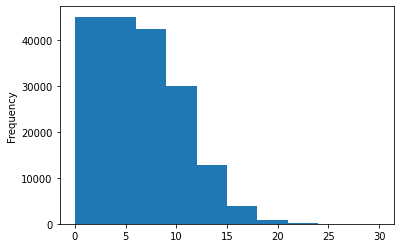

In [ ]:
# Check distribution of "line_number" column
train_df.line_number.plot.hist();

In [ ]:
# Use tensorflow to create one-hot-encoded tensors of our "line_numbers" column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
# Do the same for total lines
train_df['totalt_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: totalt_lines, dtype: int64

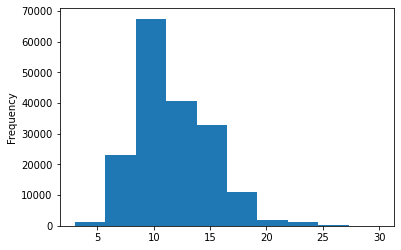

In [ ]:
train_df.totalt_lines.plot.hist();

In [ ]:
# Check the coverage with percentile
np.percentile(train_df.totalt_lines, 98)

20.0

In [ ]:
# Choose 19, but what about the one below 5?
train_total_lines_one_hot = tf.one_hot(train_df['totalt_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['totalt_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['totalt_lines'].to_numpy(), depth=20)
train_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

So we make another model and concatenate it with the two others. I can just take the char_model and token_model that is already in memory and just make the new model now. Or I can make them again to get pracdtice.

### Building a tribid embedding model

1. Create a token-level model
2. Create a character-level model  
3. Create a model for the line number feature
4. Create a model for the total line feature
5. Combine the output of 1 and 2
6. Combine the outputs 3, 4 and 5 using concatenate
7. Create an output layer to accept the tribed embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs to tf.keras.Model 

In [ ]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs, name='token_model')

# 2. Char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embedding_layer(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, return_sequences=False))(char_embedding)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm, name='char_model')

# 3. Line number 
line_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
line_outputs = tf.keras.layers.Dense(32, activation='relu')(line_inputs)
line_model = tf.keras.Model(inputs=line_inputs, outputs=line_outputs, name='Line_nr_model')

# 4. Total line number
total_line_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
total_lines_outputs = tf.keras.layers.Dense(32, activation='relu')(total_line_inputs)
total_lines_model = tf.keras.Model(inputs=total_line_inputs, outputs=total_lines_outputs, name='Total_lines_model')

# inputs, shape = ?
# dense layer with 32 units and relu activation
# combine inputs and dense layer into Model


In [ ]:
# I will continue here
# 5. Combine 1 and 2
char_token_concatenate = tf.keras.layers.Concatenate(name='token_char')([token_model.output, char_model.output])

z = tf.keras.layers.Dense(256, activation='relu')(char_token_concatenate)
z = tf.keras.layers.Dropout(0.5)(z)

# 6. Combine the outputs of 3, 4 and 5
all_combined_outputs = tf.keras.layers.Concatenate(name='all_combined')([line_model.output, total_lines_model.output, z])

# 7. Create an output layer, that is use dropout and dense etc
#all_combined_dropout = tf.keras.layers.Dropout(0.5)(all_combined_outputs)
#all_combined_dense = tf.keras.layers.Dense(128, activation='relu')(all_combined_dropout)
#final_combined_dropout = tf.keras.layers.Dropout(0.5)(all_combined_dense)
all_combined_output_layer = tf.keras.layers.Dense(5, activation='softmax', name='Output_layer')(all_combined_outputs)

# 8. Create inputs. My guess is that I take all the inputs and concatenate them
#collected_inputs = [token_model.input, char_model.input,
               #     line_model.input, total_lines_model.input]
model_5 = tf.keras.Model(inputs=[line_model.input, 
                                total_lines_model.input,
                                token_model.input, 
                                char_model.input], 
                         outputs=all_combined_output_layer,
                         name='All_combined_model')

In [ ]:
model_5.summary()

Model: "All_combined_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 Char_vecotrizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentgence_encoder (K  (None, 512)         256797824   ['token_inputs[0

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
# Compile token, char, and poistional embedding
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

What is label smoothing? 

for example if our model gets too confident on a single class (e.g. its prediction porbability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the hiughest pred prob to other classes, in turn, hopefully imporving generalization

### Create tribrid embedding dataset

Which I have tried on my own but werent that successful

In [ ]:
# I will let this stay just to remind me what I did wrong
full_train_label = tf.data.Dataset.from_tensor_slices((train_labels_one_hot, train_line_numbers_one_hot, train_total_lines_one_hot))
full_val_label = tf.data.Dataset.from_tensor_slices((val_labels_one_hot, val_line_numbers_one_hot, val_total_lines_one_hot))
full_test_label = tf.data.Dataset.from_tensor_slices((test_labels_one_hot, test_line_numbers_one_hot, test_total_lines_one_hot))

sentence_train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences))
sentence_val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences))
sentence_test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences))

full_train_data = tf.data.Dataset.zip((combined_train_data, sentence_train_dataset, sentence_train_dataset))
full_val_data = tf.data.Dataset.zip((combined_valid_data, sentence_val_dataset, sentence_val_dataset))
full_test_data = tf.data.Dataset.zip((combined_test_data, sentence_test_dataset, sentence_test_dataset))

# Combine it to get full dataset
full_train_dataset = tf.data.Dataset.zip((full_train_data, full_train_label))
full_val_dataset = tf.data.Dataset.zip((full_val_data, full_val_label))
full_test_dataset = tf.data.Dataset.zip((full_test_data, full_test_label))

# Make it fast
full_train_dataset = full_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
full_val_dataset = full_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
full_test_dataset = full_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
full_test_dataset

In [ ]:
fully_train_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                       train_total_lines_one_hot,
                                                       train_sentences,
                                                       train_chars))
fully_val_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                    val_total_lines_one_hot,
                                                    val_sentences,
                                                    val_chars))
fully_test_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                     test_total_lines_one_hot,
                                                     test_sentences,
                                                     test_chars))
fully_train_dataset = tf.data.Dataset.zip((fully_train_data, combined_train_labels))
fully_val_dataset = tf.data.Dataset.zip((fully_val_data, combined_valid_labels))
fully_test_dataset = tf.data.Dataset.zip((fully_test_data, combined_test_labels))

fully_train_dataset = fully_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
fully_val_dataset = fully_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
fully_test_dataset = fully_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
fully_train_dataset, fully_val_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

### Fitting, evaluating and predicting on the model

In [ ]:
# Compile and fit the model
history_5 = model_5.fit(fully_train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(fully_train_dataset)),
                        validation_data=fully_val_dataset,
                        validation_steps=int(0.1*len(fully_val_dataset)))

Epoch 1/3
562/562 [==============================] - 33s 52ms/step - loss: 1.0901 - accuracy: 0.7261 - val_loss: 0.9829 - val_accuracy: 0.8072
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9658 - accuracy: 0.8163 - val_loss: 0.9484 - val_accuracy: 0.8295
Epoch 3/3
562/562 [==============================] - 28s 49ms/step - loss: 0.9493 - accuracy: 0.8242 - val_loss: 0.9383 - val_accuracy: 0.8351


In [ ]:
model_5.evaluate(fully_val_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.9364 - accuracy: 0.8349


[0.9364026188850403, 0.8349331617355347]

In [ ]:
# Make predictions
model_5_pred_probs = model_5.predict(fully_val_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)


In [ ]:
model_5_result = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_5_preds)
model_5_result

{'accuracy': 83.49331391500067,
 'precision': 0.8337765190677536,
 'recall': 0.8349331391500067,
 'f1': 0.8340221723483243}